In [1]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
from snntorch import surrogate
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

In [2]:
# Check for MPS (Apple Silicon GPU) availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")

Using MPS (Apple Silicon GPU)


In [3]:
class SHDDataset(Dataset):
    def __init__(self, file_path, nb_steps=100):
        self.nb_steps = nb_steps
        self.nb_units = 700
        self.max_time = 1.4  
        
        # Load data from h5 file
        with h5py.File(file_path, 'r') as h5file:
            self.spike_times = h5file['spikes']['times'][()]
            self.spike_units = h5file['spikes']['units'][()]
            self.labels = h5file['labels'][()]
        
        # Create time bins
        self.time_bins = np.linspace(0, self.max_time, num=self.nb_steps)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        times = self.spike_times[index]
        units = self.spike_units[index]
        
        # Discretize spike times
        time_indices = np.digitize(times, self.time_bins) - 1
        
        # Create sparse tensor
        indices = torch.LongTensor(np.array([time_indices, units]))
        values = torch.FloatTensor(np.ones_like(times))
        spike_tensor = torch.sparse_coo_tensor(indices, values, size=(self.nb_steps, self.nb_units))
        
        return spike_tensor.to_dense(), self.labels[index]

def collate_fn(batch):
    # Pad sequences to the same length
    spikes, labels = zip(*batch)
    padded_spikes = torch.nn.utils.rnn.pad_sequence(spikes, batch_first=True)
    lengths = torch.LongTensor([spike.shape[0] for spike in spikes])
    labels = torch.LongTensor(labels)
    return padded_spikes, lengths, labels

def load_shd_data(train_path, test_path, batch_size=32, val_ratio=0.2):
    # Load datasets
    train_dataset = SHDDataset(train_path)
    full_test_dataset = SHDDataset(test_path)
    
    # Split test set into validation and test
    val_size = int(len(full_test_dataset) * val_ratio)
    test_size = len(full_test_dataset) - val_size
    val_dataset, test_dataset = random_split(full_test_dataset, [val_size, test_size], 
                                             generator=torch.Generator().manual_seed(42))

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, val_loader, test_loader

In [4]:
class RLIF(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, beta=0.96, threshold=1.0, 
                 spike_grad=surrogate.fast_sigmoid(), dropout_rate=0.5):
        super(RLIF, self).__init__()
        
        # Parameters
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.output_size = output_size
        self.beta = beta
        self.threshold = threshold
        
        # Layers
        self.fc_in = nn.Linear(input_size, hidden_size1)
        self.fc_hidden1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc_hidden2 = nn.Linear(hidden_size2, hidden_size3)
        self.recurrent = nn.Linear(hidden_size3, hidden_size3)
        self.fc_out = nn.Linear(hidden_size3, output_size)
        
        # Dropout layers
        self.dropout_in = nn.Dropout(dropout_rate)
        self.dropout_hidden1 = nn.Dropout(dropout_rate)
        self.dropout_hidden2 = nn.Dropout(dropout_rate)
        self.dropout_rec = nn.Dropout(dropout_rate)
        
        # LIF neuron
        self.lif = snn.Leaky(beta=beta, threshold=threshold, spike_grad=spike_grad)
        
    def forward(self, x):
        # Initialize hidden states and outputs
        batch_size = x.size(0)
        time_steps = x.size(1)
        hidden = self.lif.init_leaky()
        spk_rec = []
        mem_rec = []
        
        for step in range(time_steps):
            # Get current input
            cur_input = x[:, step, :]
            
            # First hidden layer with dropout
            z = self.dropout_in(self.fc_in(cur_input))
            z = F.relu(z)  # Apply activation function
            
            # Second hidden layer with dropout
            z = self.dropout_hidden1(self.fc_hidden1(z))
            z = F.relu(z)  # Apply activation function
            
            # Third hidden layer with dropout
            z = self.dropout_hidden2(self.fc_hidden2(z))
            
            # Add recurrent input if there was a previous spike
            if len(spk_rec) > 0:
                z += self.dropout_rec(self.recurrent(spk_rec[-1]))
            
            # LIF neuron operation
            spk, mem = self.lif(z, hidden)
            
            hidden = mem
            spk_rec.append(spk)
            mem_rec.append(mem)
        
        # Stack recorded spikes and membrane potentials
        spk_rec = torch.stack(spk_rec, dim=1)
        mem_rec = torch.stack(mem_rec, dim=1)
        
        # Read out the final layer
        outputs = self.fc_out(spk_rec)
        
        return outputs, spk_rec, mem_rec

In [5]:
# Hyperparameters
input_size = 700
hidden_size1 = 1056
hidden_size2 = 900
hidden_size3 = 900
output_size = 35
batch_size = 64
learning_rate = 0.0005
num_epochs = 30
dropout_rate = 0.5

# Load data
train_path = '/Users/solaimane/Downloads/data/ssc_train.h5'
test_path = '/Users/solaimane/Downloads/data/ssc_test.h5'
train_loader, val_loader, test_loader = load_shd_data(train_path, test_path, batch_size=batch_size)

# Initialize model, loss function, and optimizer
model = RLIF(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=5, verbose=True)
print(model)

RLIF(
  (fc_in): Linear(in_features=700, out_features=1056, bias=True)
  (fc_hidden1): Linear(in_features=1056, out_features=900, bias=True)
  (fc_hidden2): Linear(in_features=900, out_features=900, bias=True)
  (recurrent): Linear(in_features=900, out_features=900, bias=True)
  (fc_out): Linear(in_features=900, out_features=35, bias=True)
  (dropout_in): Dropout(p=0.5, inplace=False)
  (dropout_hidden1): Dropout(p=0.5, inplace=False)
  (dropout_hidden2): Dropout(p=0.5, inplace=False)
  (dropout_rec): Dropout(p=0.5, inplace=False)
  (lif): Leaky()
)


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
# Training function
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for spikes, lengths, labels in tqdm(loader, desc="Training"):
        spikes, labels = spikes.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs, _, _ = model(spikes)
        loss = criterion(outputs.mean(dim=1), labels)  # Average over time steps
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.mean(dim=1).max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), correct / total

# Evaluation function
def evaluate(model, loader, criterion, device, return_predictions=False):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for spikes, lengths, labels in tqdm(loader, desc="Evaluating"):
            spikes, labels = spikes.to(device), labels.to(device)
            
            outputs, _, _ = model(spikes)
            loss = criterion(outputs.mean(dim=1), labels)
            
            total_loss += loss.item()
            _, predicted = outputs.mean(dim=1).max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if return_predictions:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
    if return_predictions:
        return total_loss / len(loader), correct / total, all_preds, all_labels
    else:
        return total_loss / len(loader), correct / total


In [7]:
# Lists to store losses, accuracies, and learning rates
train_losses = []
train_accs = []
val_losses = []
val_accs = []
learning_rates = []

# Training loop
best_val_acc = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Record losses, accuracies, and current learning rate
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Step the scheduler
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model")
    
    print()

Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.45it/s]


Epoch 1/30
Train Loss: 2.9069, Train Acc: 0.1793
Val Loss: 2.4667, Val Acc: 0.2782
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:10<00:00,  5.55it/s]


Epoch 2/30
Train Loss: 2.3403, Train Acc: 0.3236
Val Loss: 2.2704, Val Acc: 0.3207
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.43it/s]


Epoch 3/30
Train Loss: 2.1246, Train Acc: 0.3869
Val Loss: 1.9239, Val Acc: 0.4372
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.43it/s]


Epoch 4/30
Train Loss: 1.9596, Train Acc: 0.4369
Val Loss: 1.7745, Val Acc: 0.4730
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.41it/s]


Epoch 5/30
Train Loss: 1.8344, Train Acc: 0.4697
Val Loss: 1.7189, Val Acc: 0.4885
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.33it/s]


Epoch 6/30
Train Loss: 1.7578, Train Acc: 0.4901
Val Loss: 1.8202, Val Acc: 0.4612
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.27it/s]


Epoch 7/30
Train Loss: 1.6843, Train Acc: 0.5097
Val Loss: 1.5694, Val Acc: 0.5169
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.32it/s]


Epoch 8/30
Train Loss: 1.6307, Train Acc: 0.5224
Val Loss: 1.5199, Val Acc: 0.5488
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.28it/s]


Epoch 9/30
Train Loss: 1.5857, Train Acc: 0.5362
Val Loss: 1.4827, Val Acc: 0.5520
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.29it/s]


Epoch 10/30
Train Loss: 1.5468, Train Acc: 0.5471
Val Loss: 1.4733, Val Acc: 0.5618
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.14it/s]


Epoch 11/30
Train Loss: 1.5079, Train Acc: 0.5587
Val Loss: 1.4118, Val Acc: 0.5763
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.29it/s]


Epoch 12/30
Train Loss: 1.4764, Train Acc: 0.5658
Val Loss: 1.4626, Val Acc: 0.5545
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.08it/s]


Epoch 13/30
Train Loss: 1.4451, Train Acc: 0.5760
Val Loss: 1.3916, Val Acc: 0.5785
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:10<00:00,  5.49it/s]


Epoch 14/30
Train Loss: 1.4286, Train Acc: 0.5789
Val Loss: 1.4562, Val Acc: 0.5618
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.44it/s]


Epoch 15/30
Train Loss: 1.4039, Train Acc: 0.5865
Val Loss: 1.3832, Val Acc: 0.5812
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:10<00:00,  5.48it/s]


Epoch 16/30
Train Loss: 1.3781, Train Acc: 0.5936
Val Loss: 1.4058, Val Acc: 0.5682
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.35it/s]


Epoch 17/30
Train Loss: 1.3632, Train Acc: 0.5989
Val Loss: 1.3780, Val Acc: 0.5832
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.38it/s]


Epoch 18/30
Train Loss: 1.3490, Train Acc: 0.6028
Val Loss: 1.3444, Val Acc: 0.5945
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:10<00:00,  5.47it/s]


Epoch 19/30
Train Loss: 1.3311, Train Acc: 0.6054
Val Loss: 1.3589, Val Acc: 0.5942
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.32it/s]


Epoch 20/30
Train Loss: 1.3108, Train Acc: 0.6130
Val Loss: 1.3401, Val Acc: 0.5947
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:10<00:00,  5.46it/s]


Epoch 21/30
Train Loss: 1.2930, Train Acc: 0.6166
Val Loss: 1.4371, Val Acc: 0.5743
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.25it/s]


Epoch 22/30
Train Loss: 1.2863, Train Acc: 0.6190
Val Loss: 1.4442, Val Acc: 0.5731
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.26it/s]


Epoch 23/30
Train Loss: 1.2747, Train Acc: 0.6221
Val Loss: 1.3488, Val Acc: 0.5969
Learning Rate: 0.000500
Saved best model



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.29it/s]


Epoch 24/30
Train Loss: 1.2571, Train Acc: 0.6257
Val Loss: 1.4224, Val Acc: 0.5812
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.26it/s]


Epoch 25/30
Train Loss: 1.2556, Train Acc: 0.6265
Val Loss: 1.4395, Val Acc: 0.5783
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.17it/s]


Epoch 26/30
Train Loss: 1.2379, Train Acc: 0.6308
Val Loss: 1.3861, Val Acc: 0.5910
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.31it/s]


Epoch 27/30
Train Loss: 1.2258, Train Acc: 0.6350
Val Loss: 1.4242, Val Acc: 0.5802
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:10<00:00,  5.48it/s]


Epoch 28/30
Train Loss: 1.2231, Train Acc: 0.6372
Val Loss: 1.4137, Val Acc: 0.5815
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.43it/s]


Epoch 29/30
Train Loss: 1.2244, Train Acc: 0.6333
Val Loss: 1.4405, Val Acc: 0.5763
Learning Rate: 0.000500



Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.42it/s]


Epoch 30/30
Train Loss: 1.1491, Train Acc: 0.6574
Val Loss: 1.4155, Val Acc: 0.5974
Learning Rate: 0.000350
Saved best model



/var/folders/5j/29b3x65115q5_q5nrhxn_r680000gn/T/ipykernel_14853/3094697580.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

Test Loss: 1.4408, Test Acc: 0.5922

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       621
           1       0.56      0.66      0.61       593
           2       0.51      0.69      0.58       617
           3       0.59      0.56      0.58       602
           4       0.46      0.71      0.56       565
           5       0.69      0.44      0.53       651
           6       0.90      0.70      0.79       586
           7       0.87      0.50      0.64       616
           8       0.77      0.74      0.76       582
           9       0.68      0.66      0.67       604
          10       0.59      0.50      0.54       581
          11       0.29      0.39      0.33       235
          12       0.45      0.79      0.57       576
          13       0.87      0.59      0.71       629
          14       0.70      0.52      0.60       588
          15       0.94      0.36      0.52       313
          16       0.

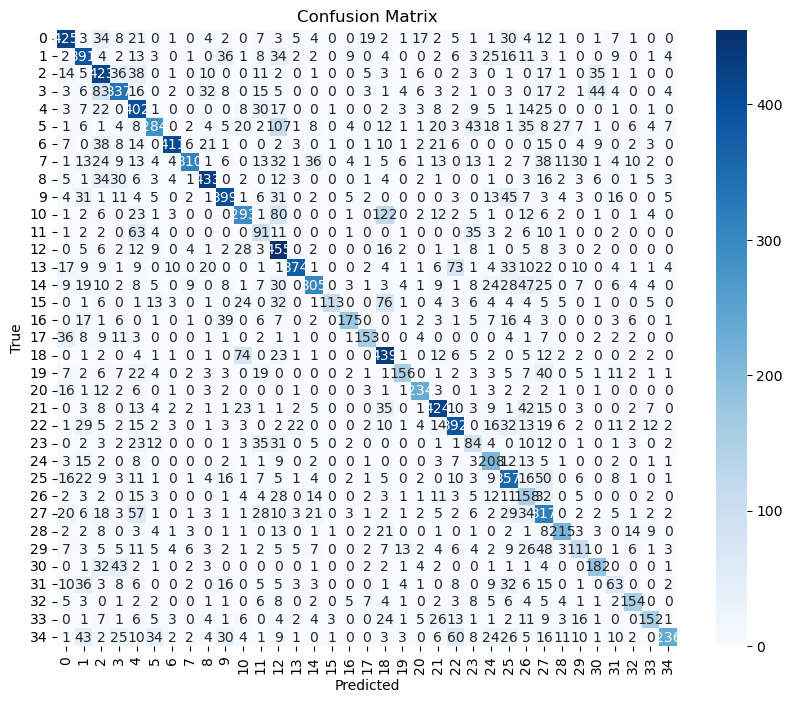

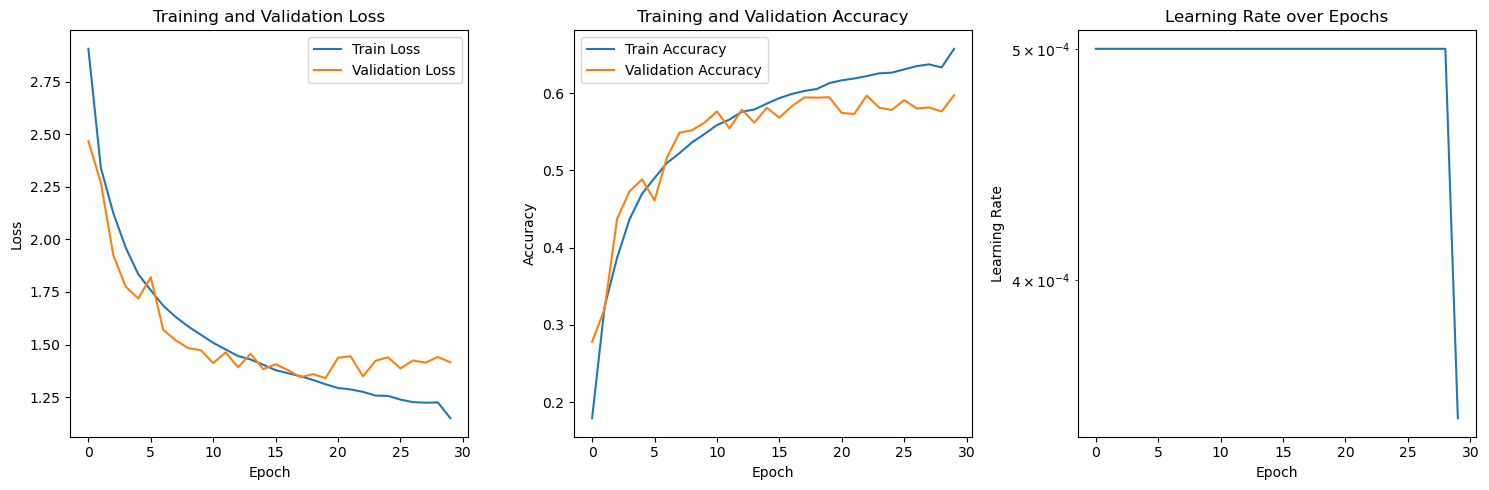


Best validation accuracy: 0.5974 at epoch 30


In [8]:
# Evaluate on test set and get predictions
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device, return_predictions=True)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training and validation curves
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot learning rate
plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.yscale('log')

plt.tight_layout()
plt.show()

# Print best validation accuracy and corresponding epoch
best_epoch = val_accs.index(max(val_accs)) + 1
print(f"\nBest validation accuracy: {max(val_accs):.4f} at epoch {best_epoch}")